In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from IPython import display
plt.style.use('seaborn')
sns.set()

In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp

def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp

def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal

def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal

def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves

def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves

def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs

def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw

def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps

def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps

def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs

def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw

def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]
        return insertions

def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions

def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp

def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp

def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal

def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal

def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp

def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

def normalize_depth(depth, depth_min, depth_max):
    return (depth - depth_min) / (depth_max - depth_min)

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
green_list_df = pd.read_csv('data/Green_misc_insertions_210530.csv')
date = '5/30/21'
bath_df = green_list_df.loc[green_list_df['date'] == date]

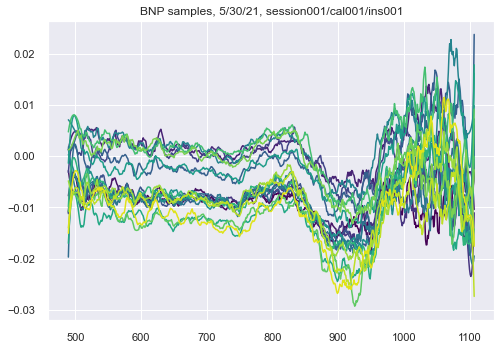

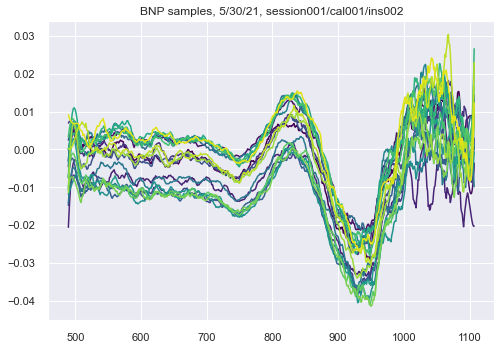

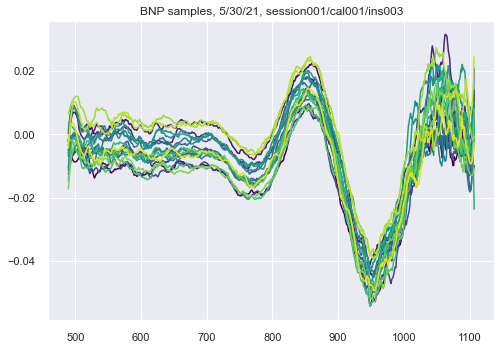

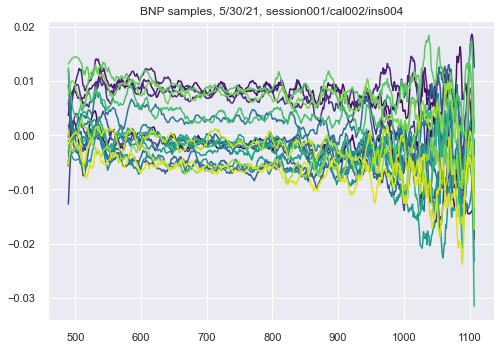

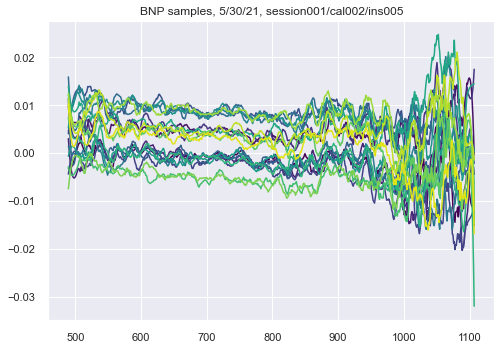

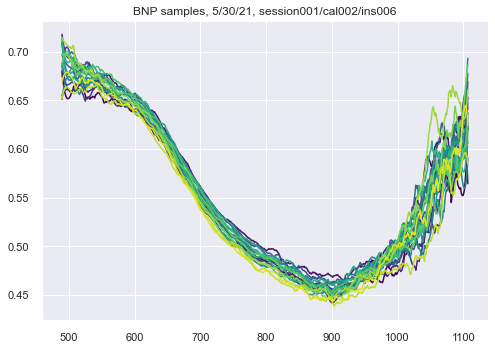

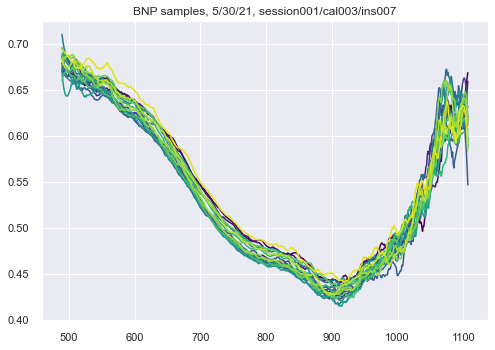

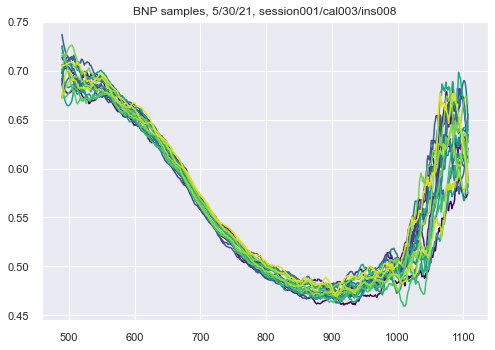

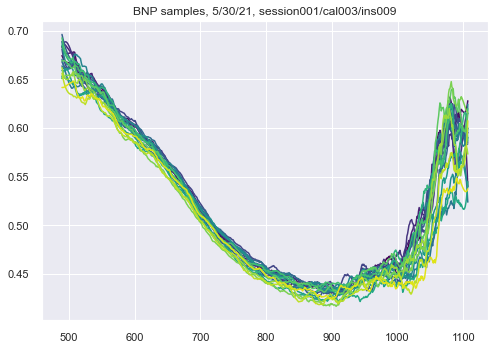

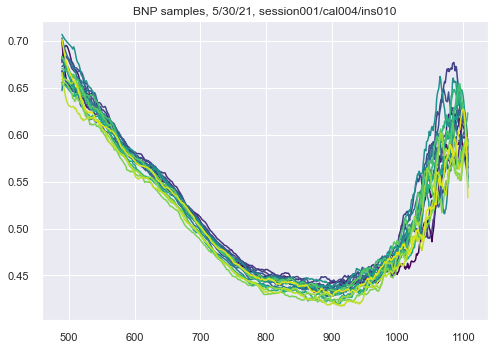

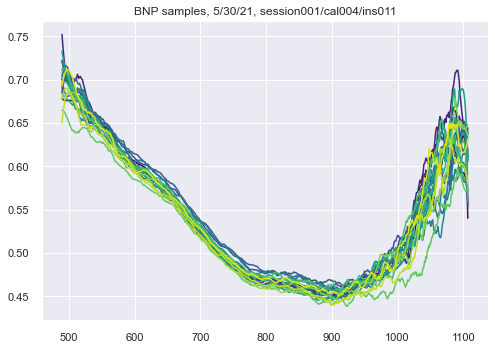

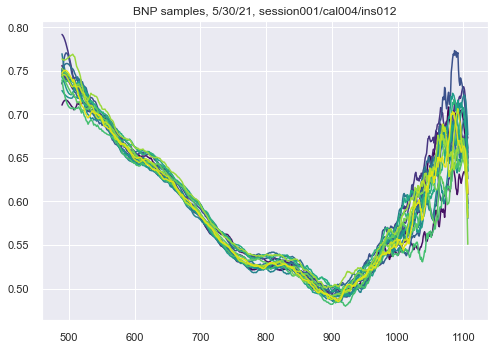

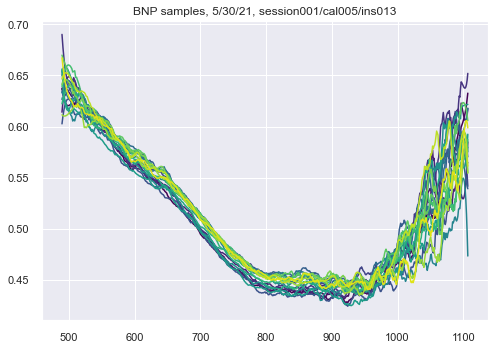

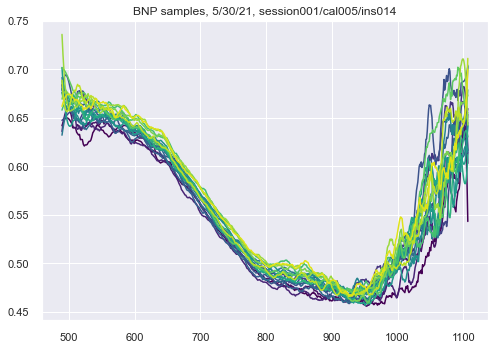

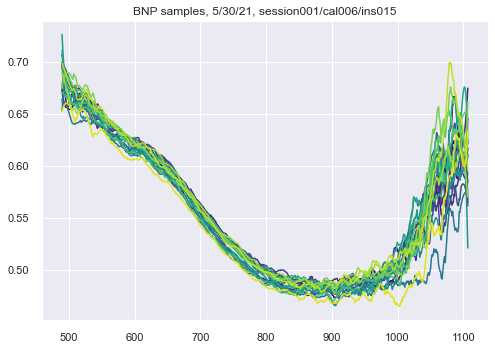

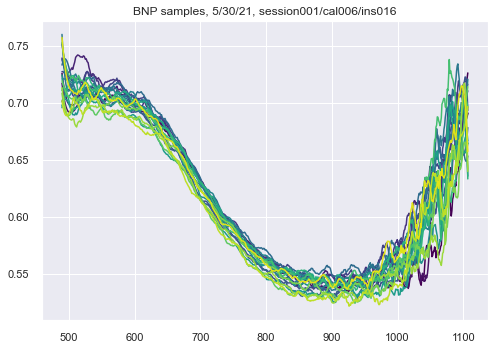

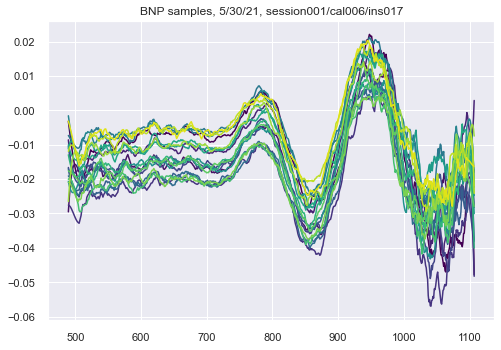

In [4]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = bath_df.iat[0, 0]
file = path_name + file_name

for index in bath_df.index.values:
    session = bath_df['session'][index]
    calibration = bath_df['calibration'][index]
    insertion = bath_df['insertion'][index]
    cal_path = f'{session}/{calibration}'
    with h5py.File(file, 'r') as h5_file:
        absorbances = h5_file[f'{session}/{calibration}/{insertion}/spectrometer1/derived/absorbances'][:]
    waves = get_visible_wavelength_vector(file, cal_path)
    
    fig, ax = plt.subplots()
    ax.set_title(f"BNP samples, 5/30/21, {cal_path}/{insertion}")
    # ax.set_ylim(0.3, 0.9)
    for i in range(absorbances.shape[0]):
        color = plt.cm.viridis(normalize_depth(i, 0, absorbances.shape[0]))
        ax.plot(waves, savgol_filter(absorbances[i, :], 21, 3), color=color, label=i)
    #plt.legend(bbox_to_anchor=(1.05, 0.9, 0.3, 0.2), loc='upper left')
    plt.show()
    plt.close()

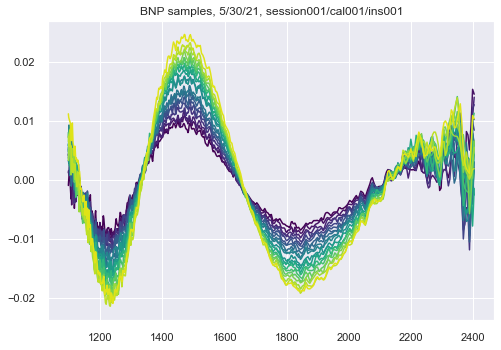

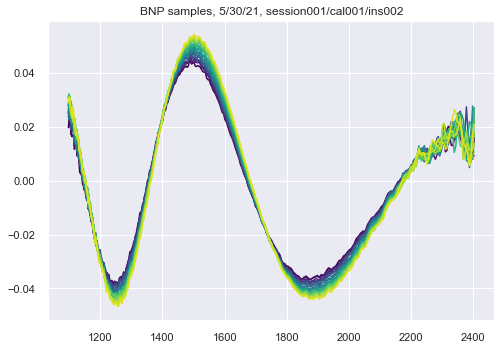

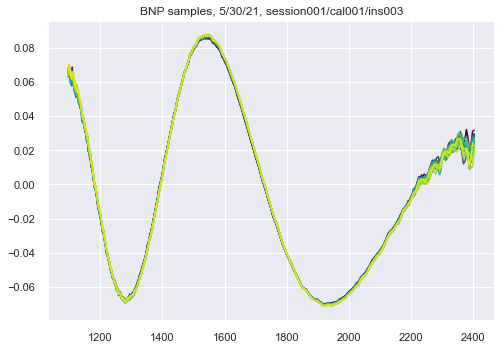

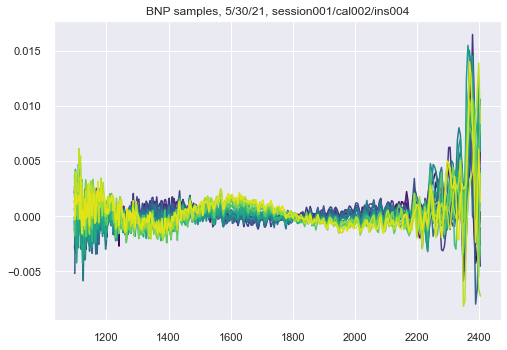

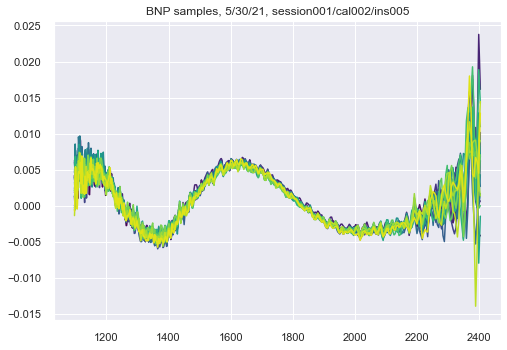

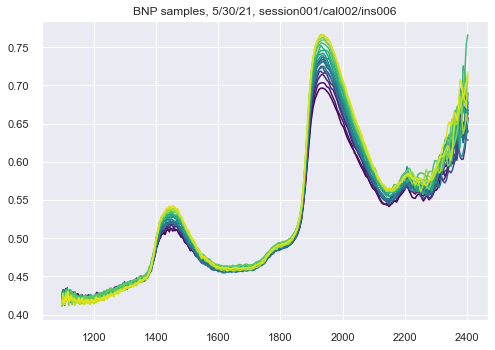

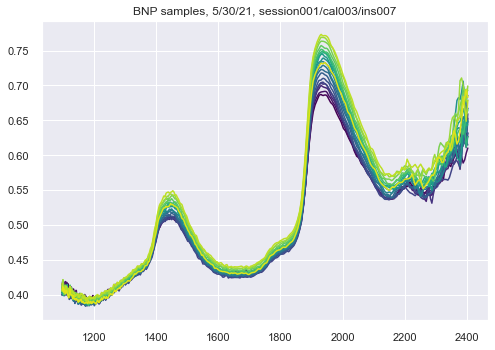

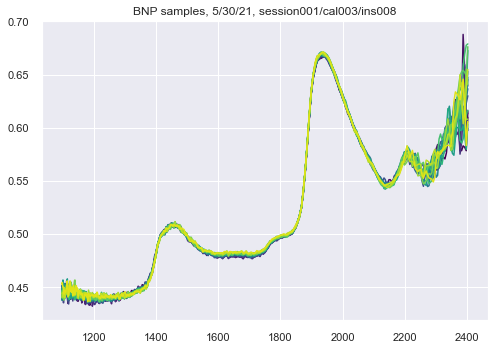

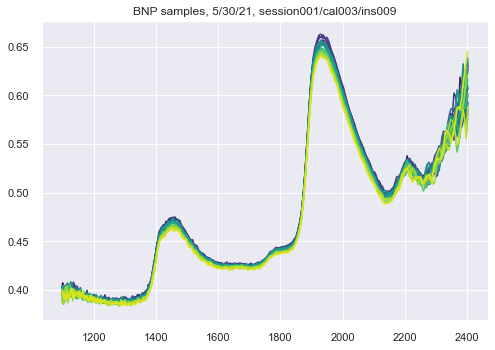

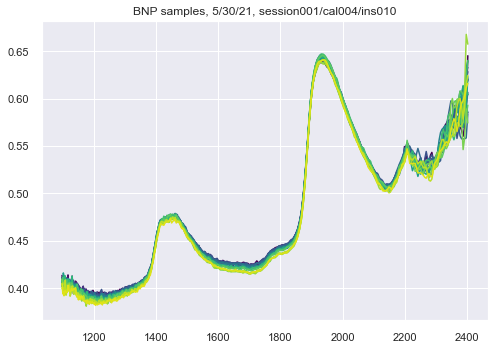

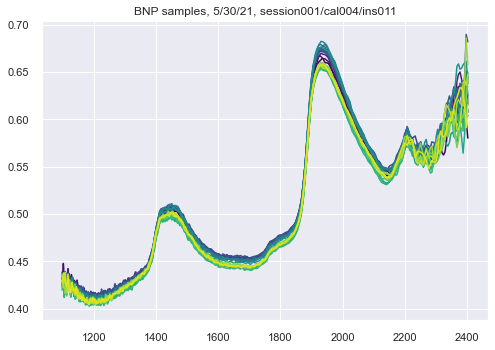

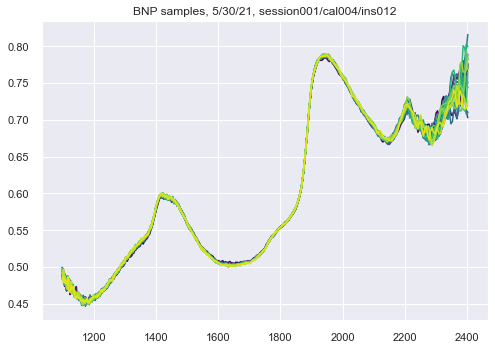

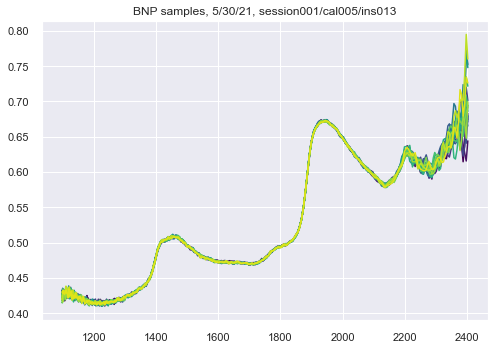

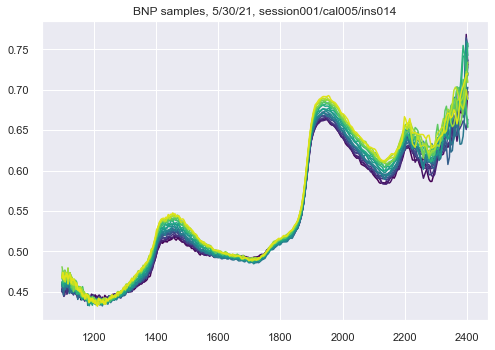

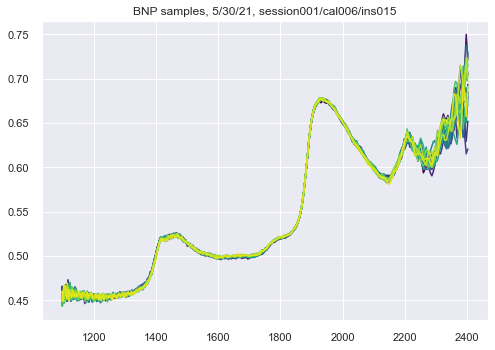

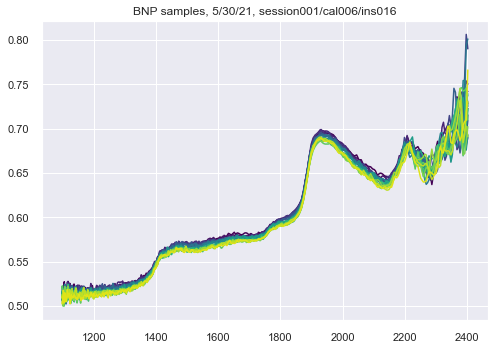

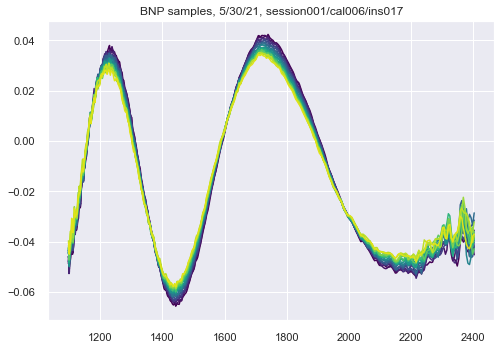

In [5]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
file_name = bath_df.iat[0, 0]
file = path_name + file_name

for index in bath_df.index.values:
    session = bath_df['session'][index]
    calibration = bath_df['calibration'][index]
    insertion = bath_df['insertion'][index]
    cal_path = f'{session}/{calibration}'
    with h5py.File(file, 'r') as h5_file:
        absorbances = h5_file[f'{session}/{calibration}/{insertion}/spectrometer2/derived/absorbances'][:, 100:666]
    waves = get_ftir_wavelength_vector(file, cal_path)[100:666]
    
    fig, ax = plt.subplots()
    ax.set_title(f"BNP samples, 5/30/21, {cal_path}/{insertion}")
    # ax.set_ylim(0.3, 0.9)
    for i in range(absorbances.shape[0]):
        color = plt.cm.viridis(normalize_depth(i, 0, absorbances.shape[0]))
        ax.plot(waves, absorbances[i, :], color=color, label=i)
    #plt.legend(bbox_to_anchor=(1.05, 0.9, 0.3, 0.2), loc='upper left')
    plt.show()
    plt.close()

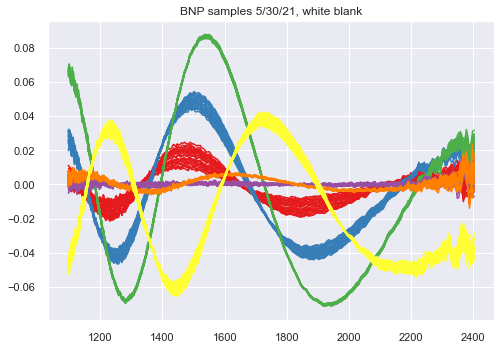

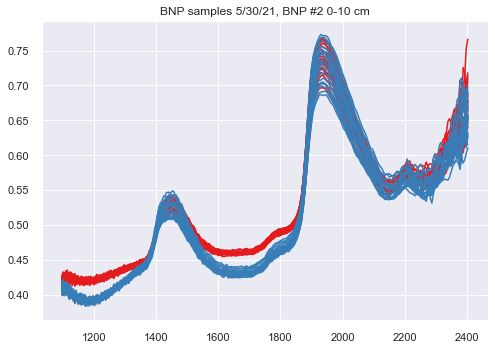

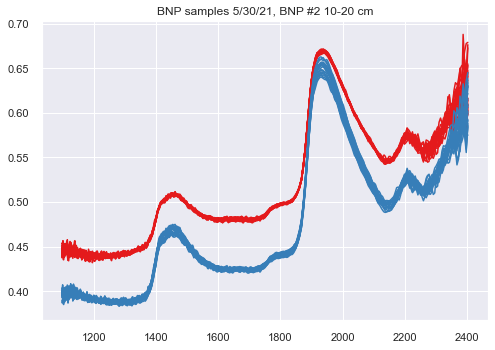

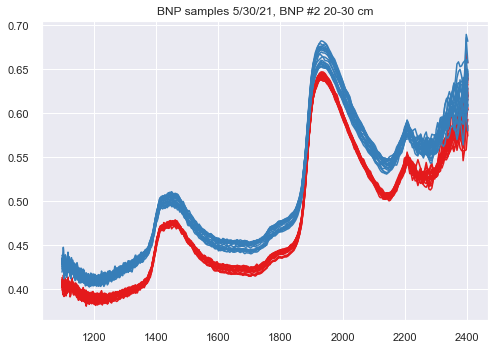

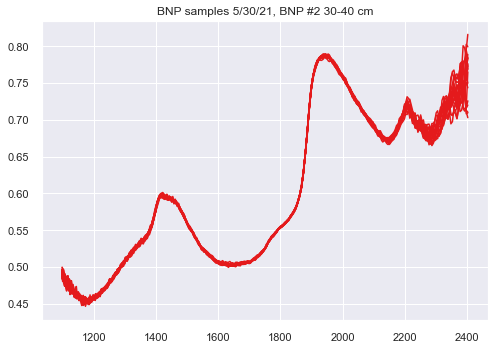

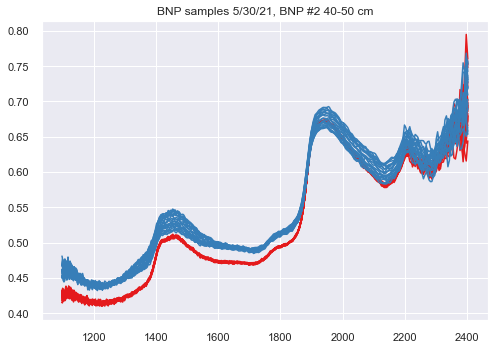

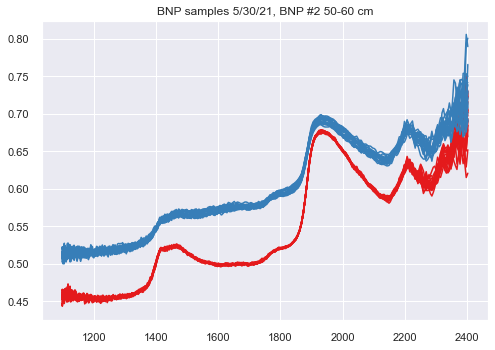

In [6]:
conditions = bath_df['target'].unique()
for condition in conditions:    

    path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
    file_name = bath_df.iat[0, 0]
    file = path_name + file_name        
    fig, ax = plt.subplots()
    # ax.set_ylim(0.3, 0.9)
    ax.set_title(f"BNP samples 5/30/21, {condition}")
    t1 = bath_df.loc[bath_df['target'] == condition]
    for index in t1.index.values:
        unique_insertions = t1['insertion'].unique()
        rgb_values = sns.color_palette("Set1", t1.shape[0])
        color_map = dict(zip(unique_insertions, rgb_values))

        session = bath_df['session'][index]
        calibration = bath_df['calibration'][index]
        insertion = bath_df['insertion'][index]
        cal_path = f'{session}/{calibration}'
        target = bath_df['target'][index]
        with h5py.File(file, 'r') as h5_file:
            absorbances = h5_file[f'{session}/{calibration}/{insertion}/spectrometer2/derived/absorbances'][:, 100:666]
        waves = get_ftir_wavelength_vector(file, cal_path)[100:666]
        for i in range(absorbances.shape[0]):
            color = color_map[insertion]
            ax.plot(waves,
                    absorbances[i, :],
                    color=color, label=target)
    # plt.legend(bbox_to_anchor=(1.05, 0.8, 0.3, 0.2), loc='upper left')

    plt.show()
    plt.close()

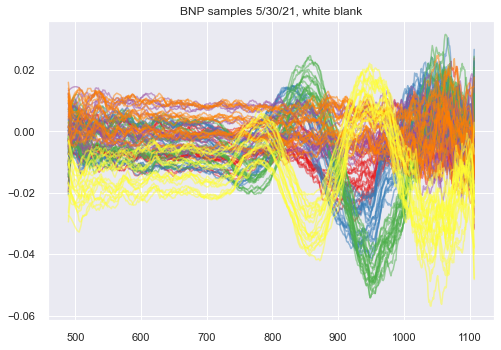

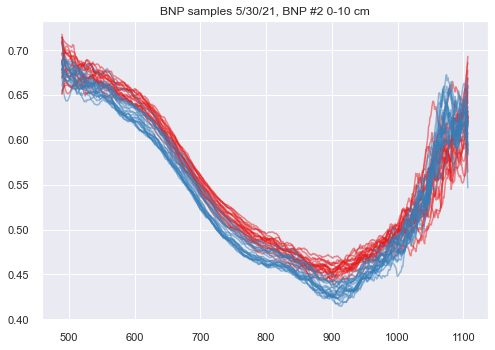

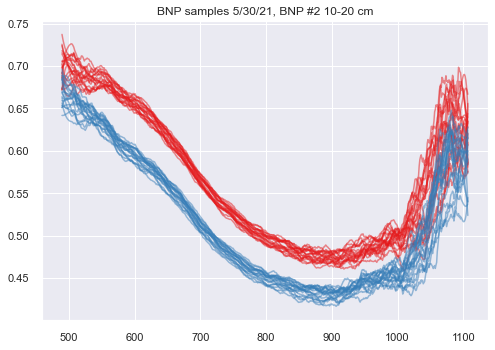

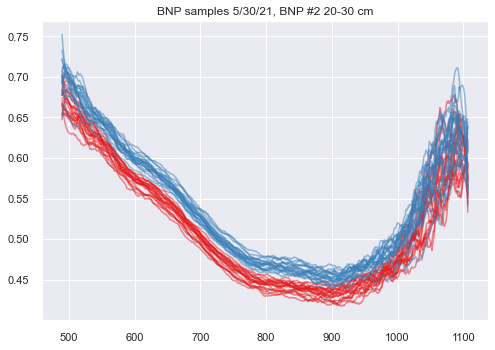

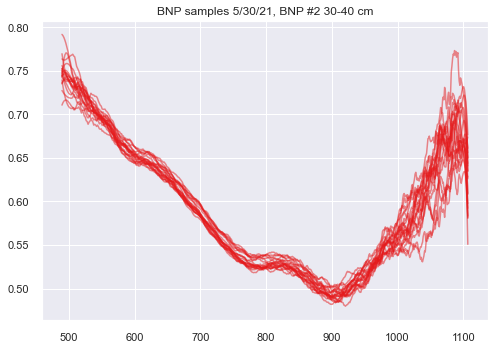

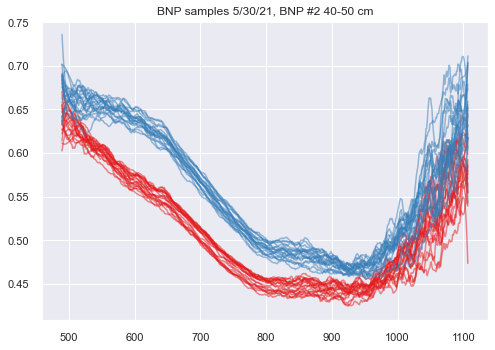

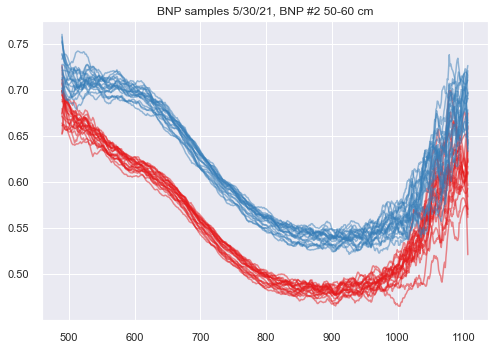

In [7]:
conditions = bath_df['target'].unique()
for condition in conditions:    

    path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
    file_name = bath_df.iat[0, 0]
    file = path_name + file_name        
    fig, ax = plt.subplots()
    # ax.set_ylim(0.3, 0.9)
    ax.set_title(f"BNP samples 5/30/21, {condition}")
    t1 = bath_df.loc[bath_df['target'] == condition]
    for index in t1.index.values:
        unique_insertions = t1['insertion'].unique()
        rgb_values = sns.color_palette("Set1", t1.shape[0])
        color_map = dict(zip(unique_insertions, rgb_values))

        session = bath_df['session'][index]
        calibration = bath_df['calibration'][index]
        insertion = bath_df['insertion'][index]
        cal_path = f'{session}/{calibration}'
        target = bath_df['target'][index]
        with h5py.File(file, 'r') as h5_file:
            absorbances = h5_file[f'{session}/{calibration}/{insertion}/spectrometer1/derived/absorbances'][:]
        waves = get_visible_wavelength_vector(file, cal_path)
        for i in range(absorbances.shape[0]):
            color = color_map[insertion]
            ax.plot(waves,
                    savgol_filter(absorbances[i, :], 21, 3),
                    color=color, label=target, alpha=0.5)
    # plt.legend(bbox_to_anchor=(1.05, 0.8, 0.3, 0.2), loc='upper left')

    plt.show()
    plt.close()